In [1]:
#import standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from random import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Flatten

In [2]:
#import project libs
from PowerAIDataHandler import ClassPowerAIDataHandler

#corrupt timestamps: Time frame: 1728835915654/1728845708532/
#  Sprung zwischen 1728835995276 und 1728845640410

In [3]:
#init datahandler using configuration from .env
dh = ClassPowerAIDataHandler("C:/Users/Kids/iCloudDrive/Documents/GitHub/PowerAI/.env")

#init parameters for neural network
num_devices   = len(dh.device_list)   #länge der Gerätliste
event_ratio   = 0.5 #Verhältnis Trainings-/Testdaten
window_length = 15 #Anzahl an Daten die gleichzeitig eingespeist werden
epochs        = 100 #Anzahl der Traings-/Testdurchläufe

C:\Users\Kids\iCloudDrive\Documents\GitHub\PowerAI\PowerAIDataHandler.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure()


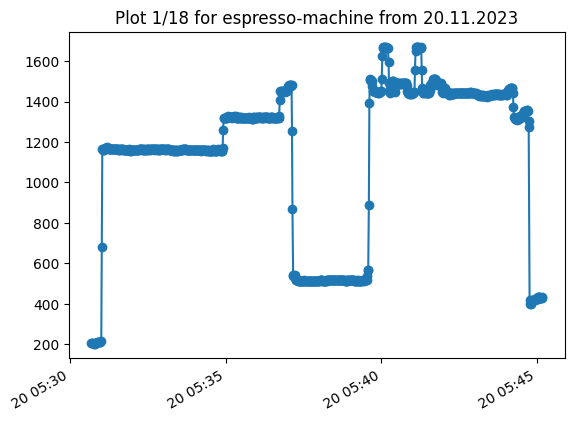

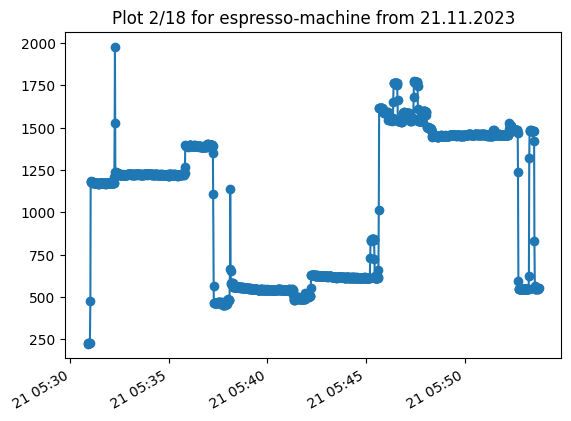

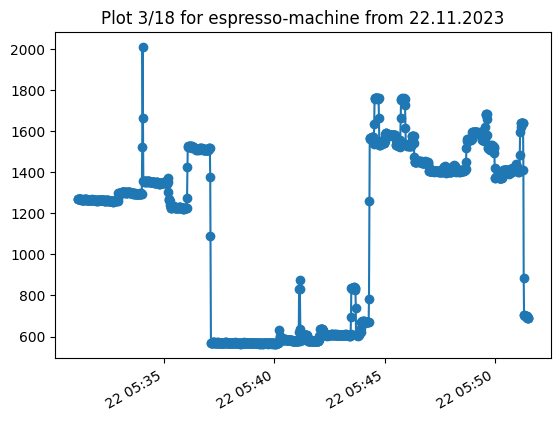

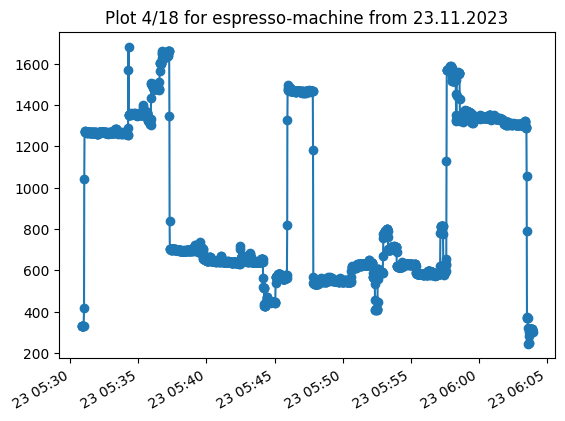

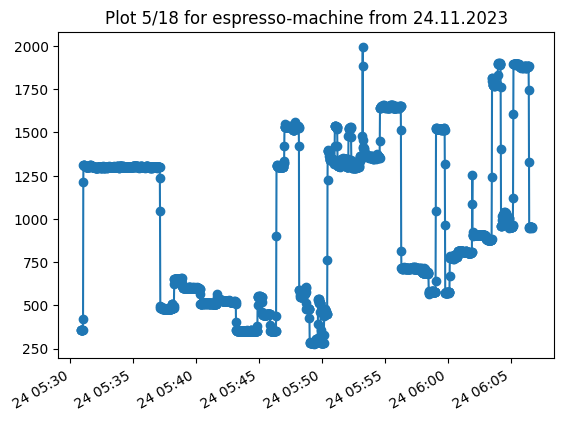

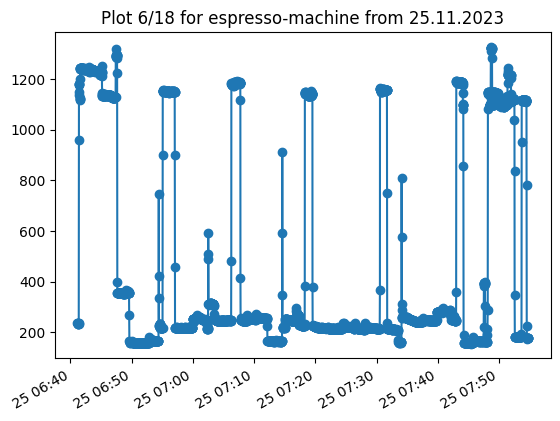

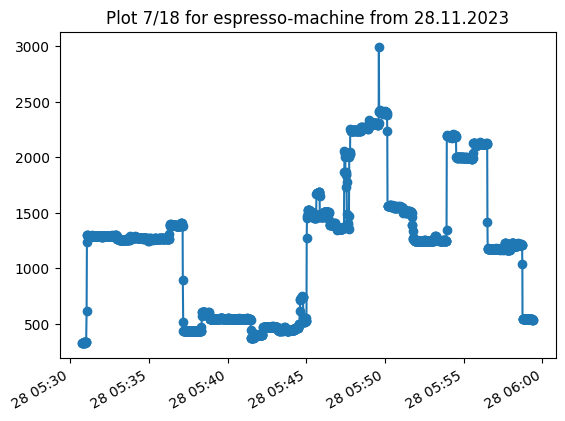

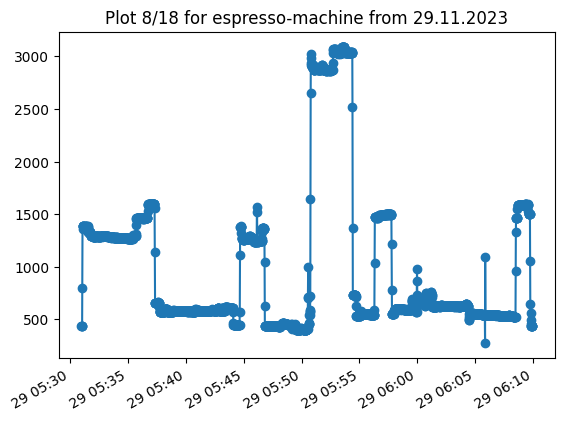

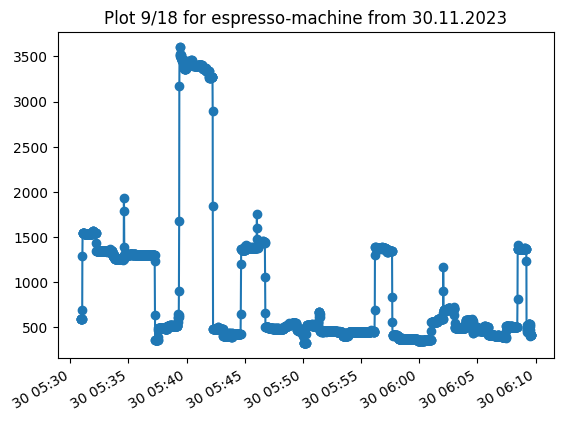

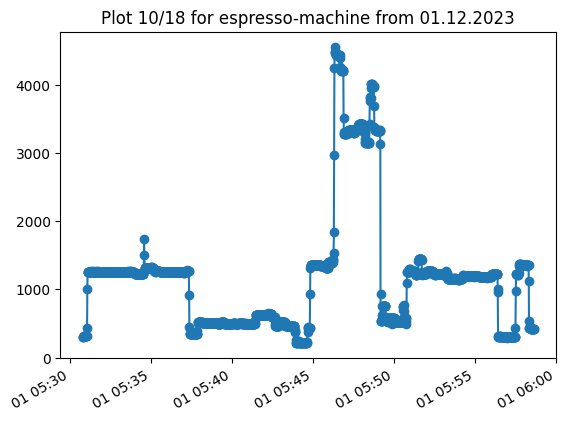

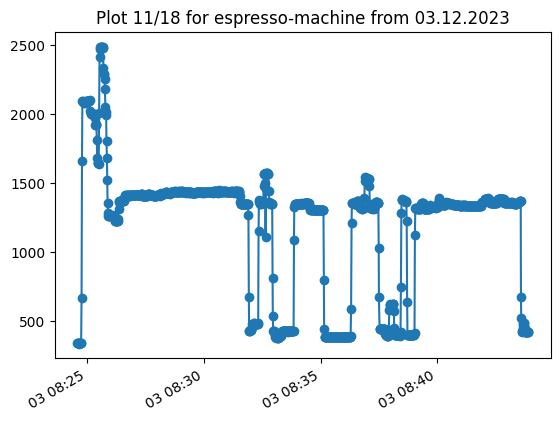

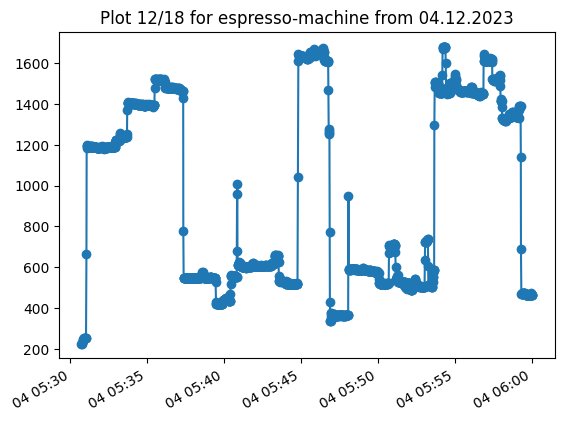

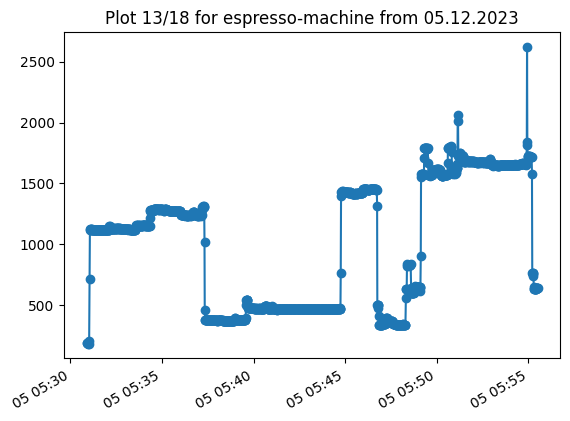

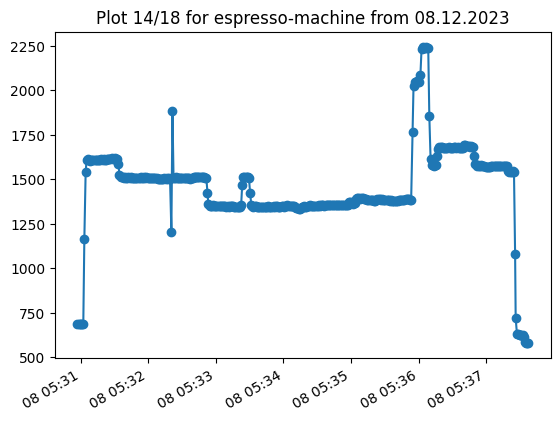

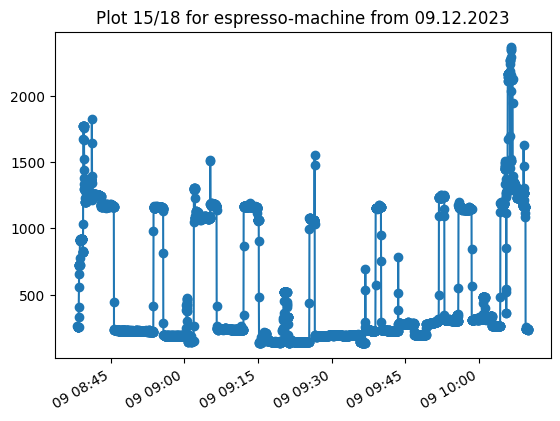

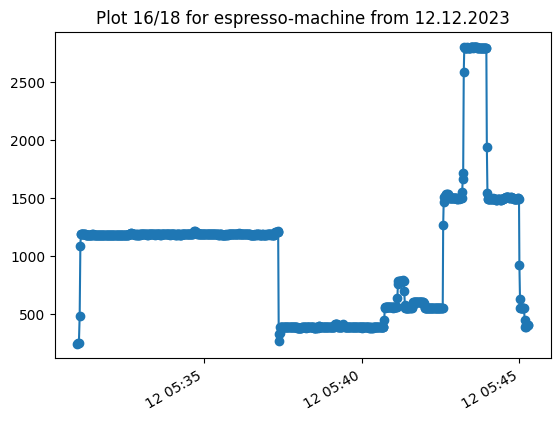

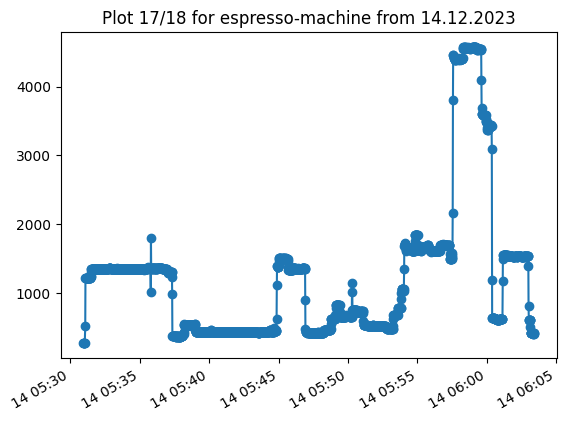

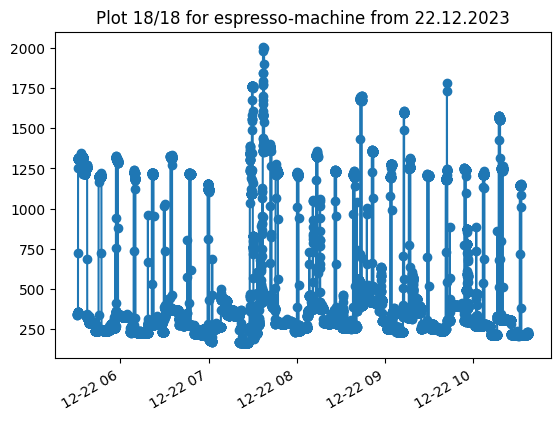

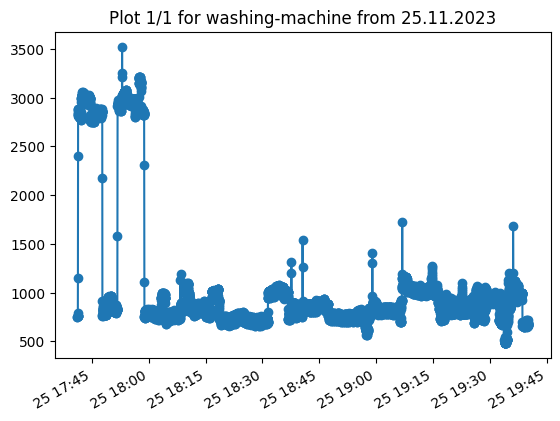

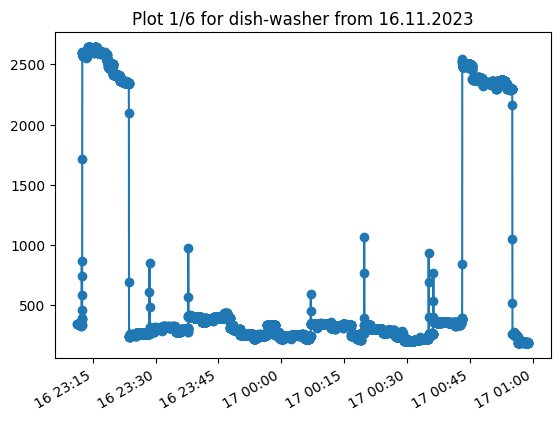

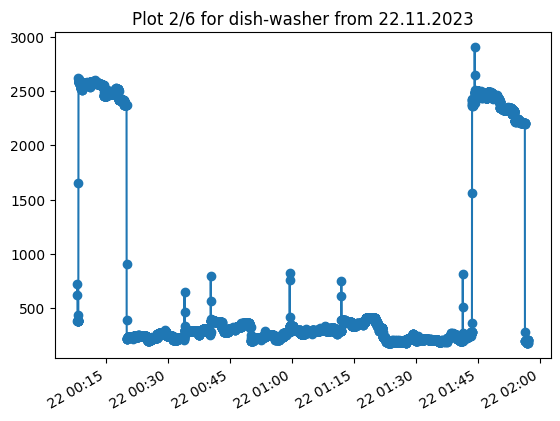

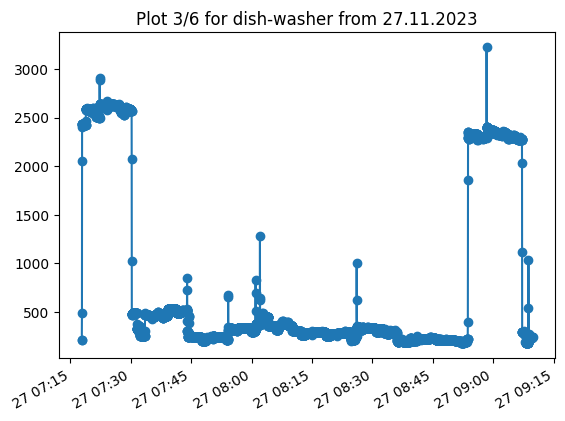

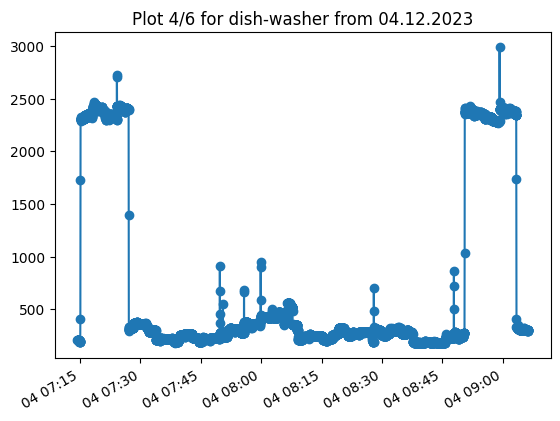

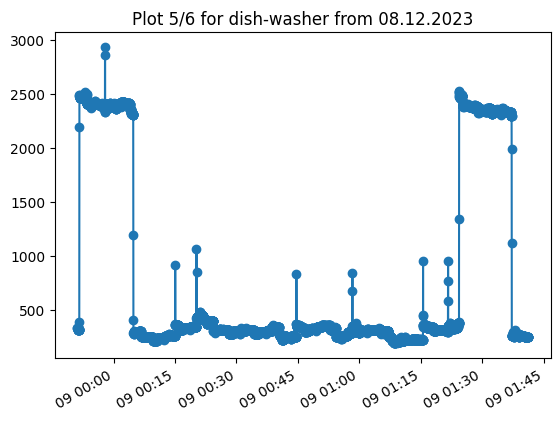

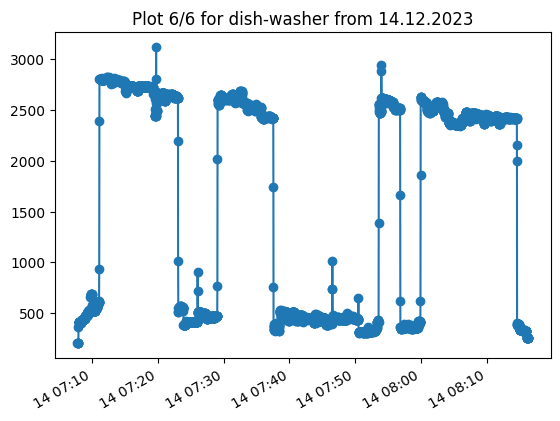

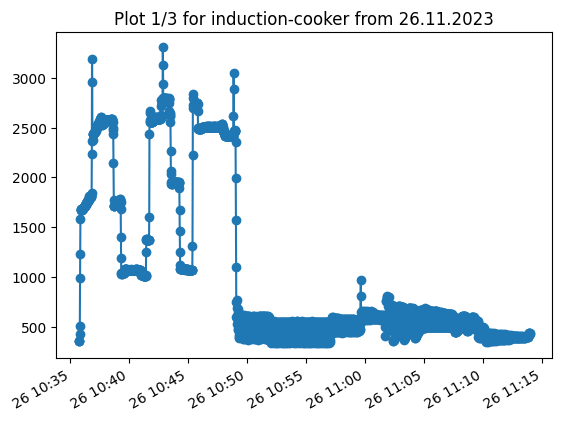

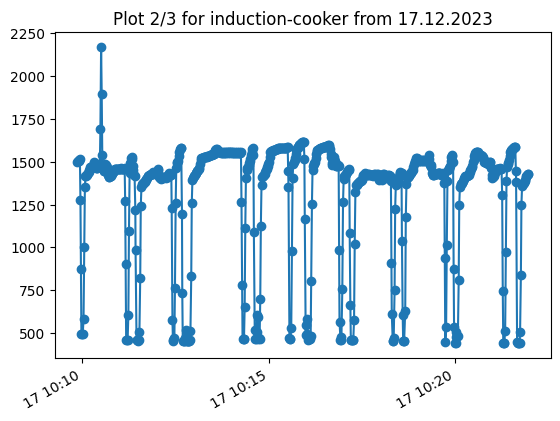

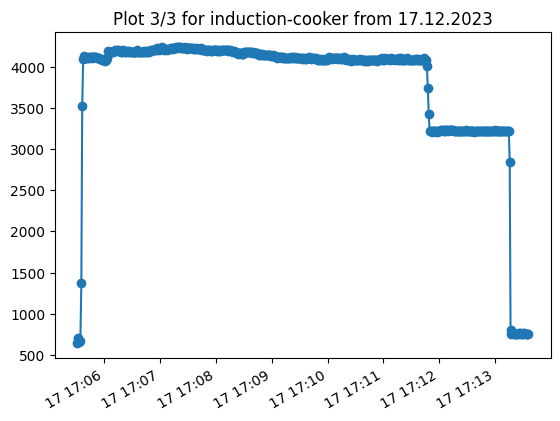

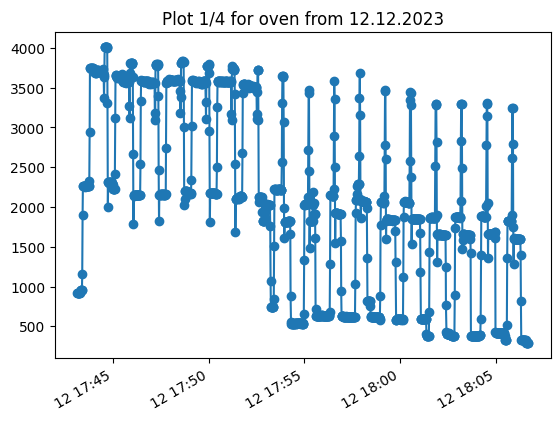

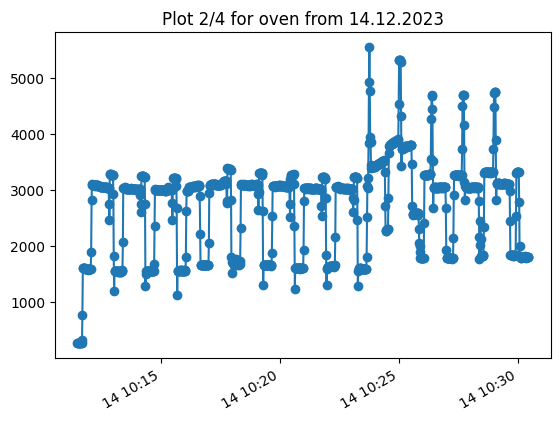

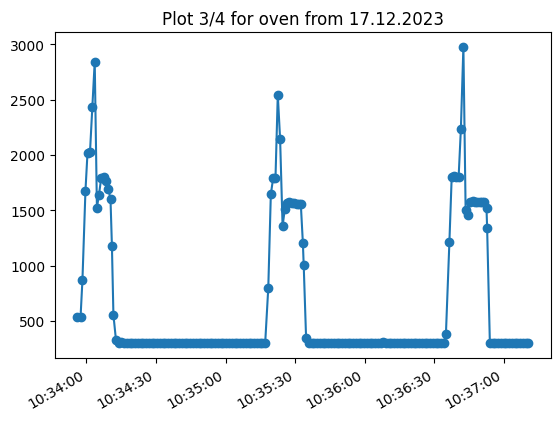

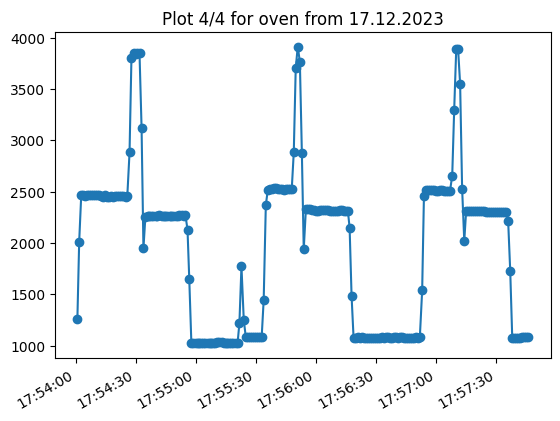

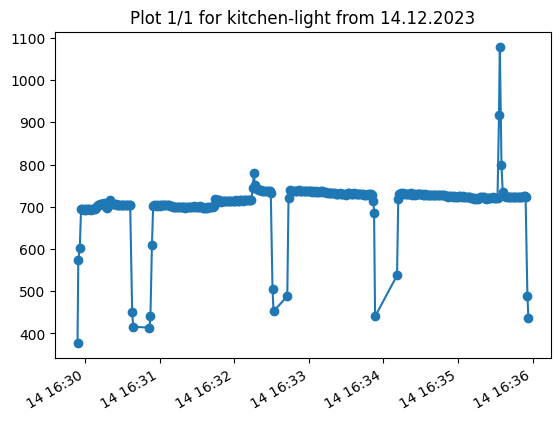

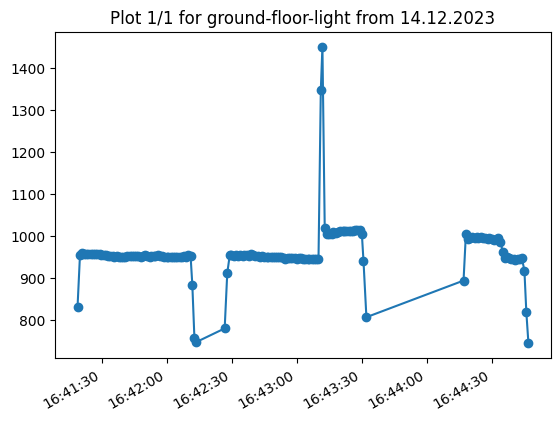

In [4]:
#read the calssified events from the mysql database
dh.read_events_from_db()

#print timeserie of the events
dh.print_events()

C:\Users\Kids\iCloudDrive\Documents\GitHub\PowerAI\PowerAIDataHandler.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure()


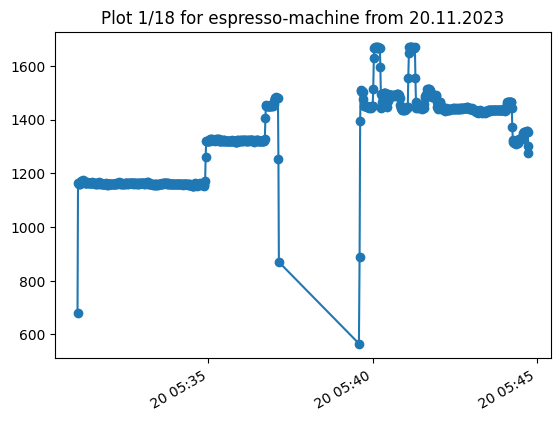

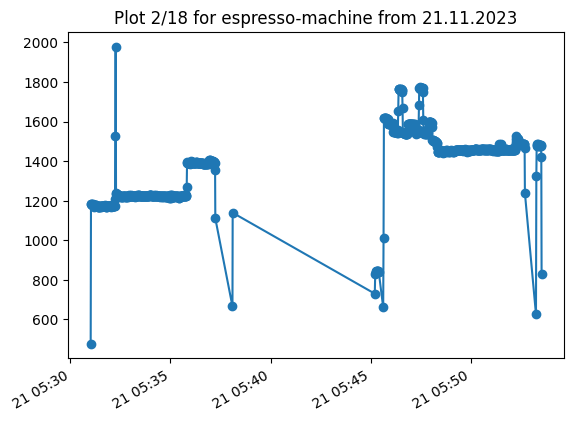

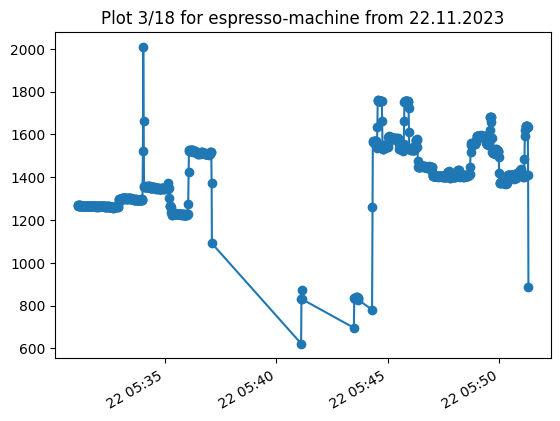

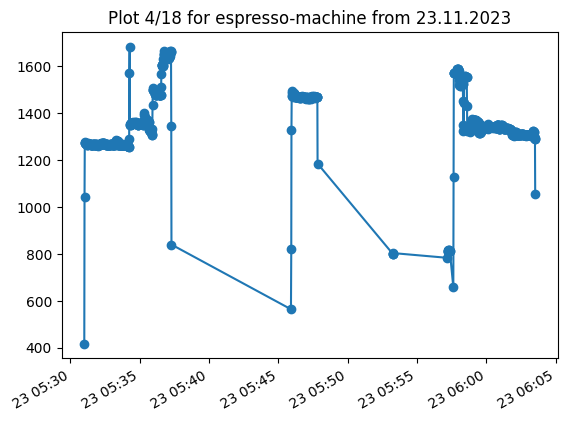

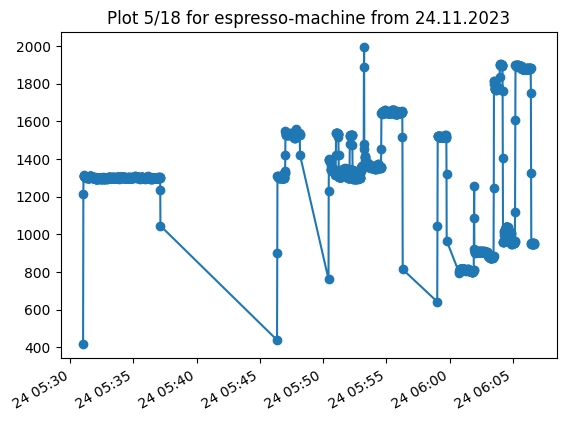

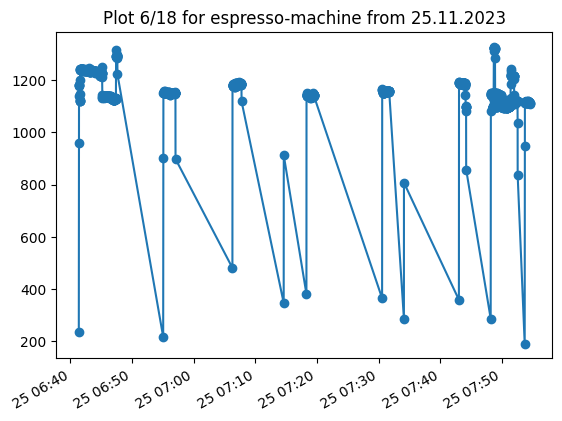

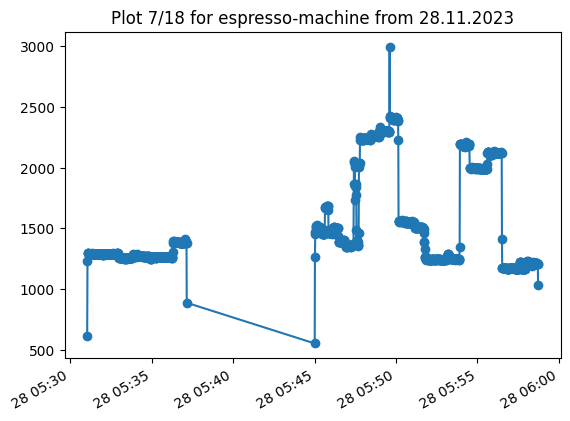

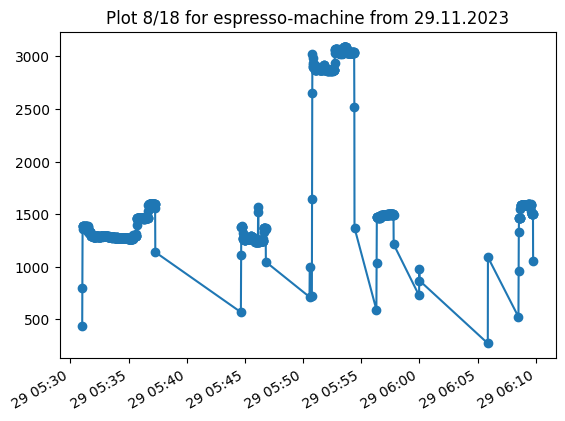

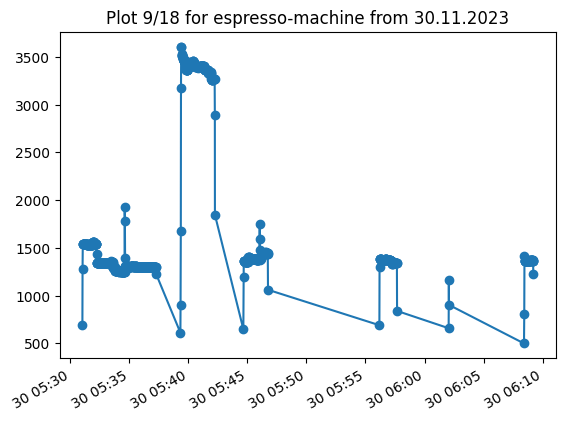

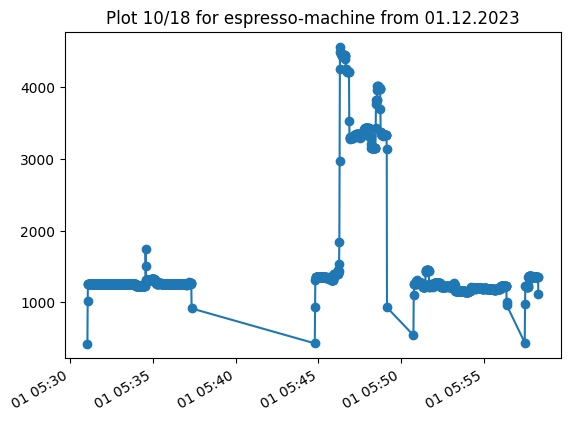

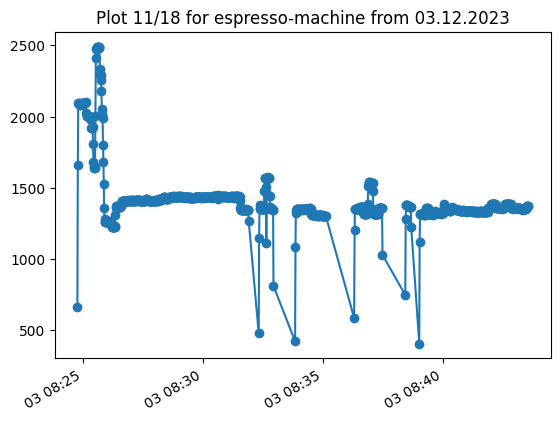

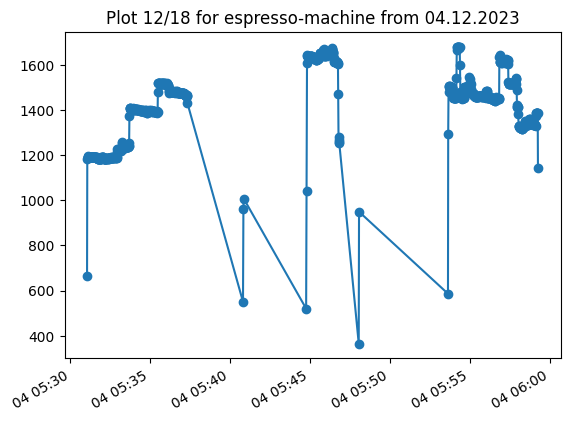

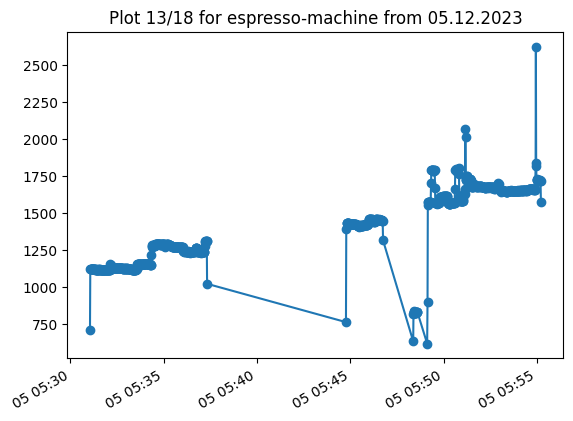

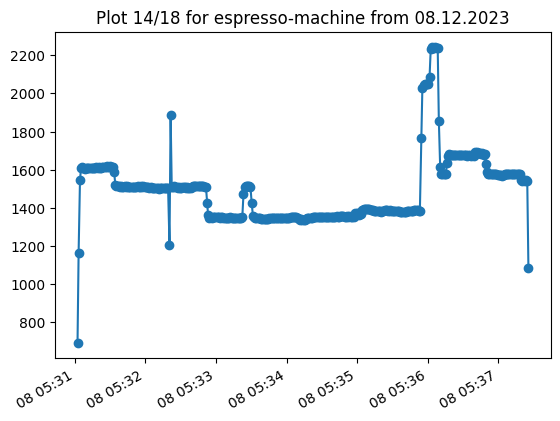

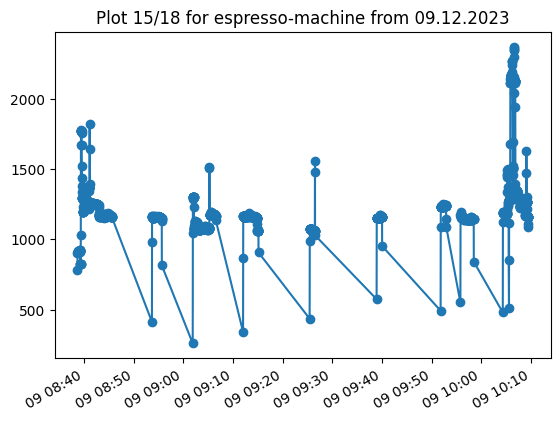

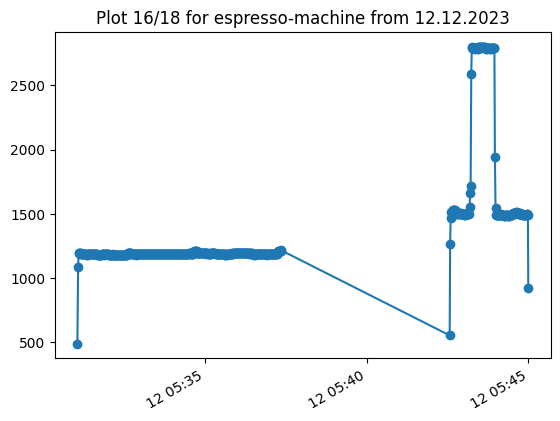

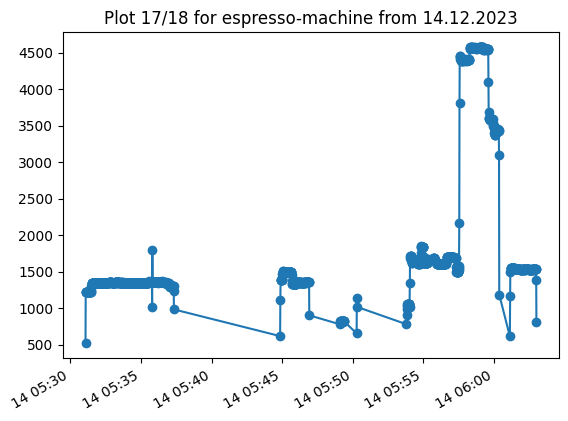

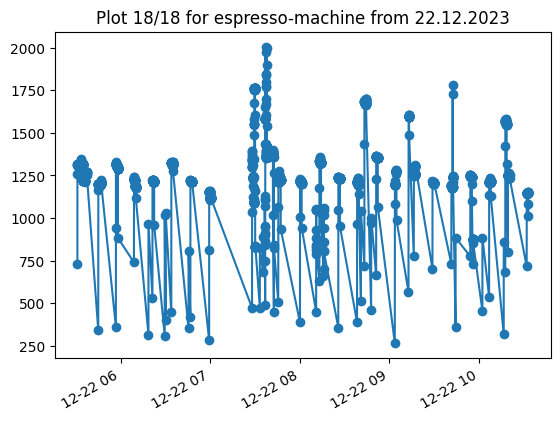

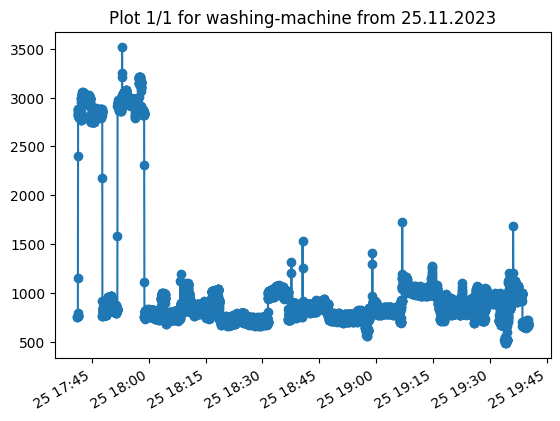

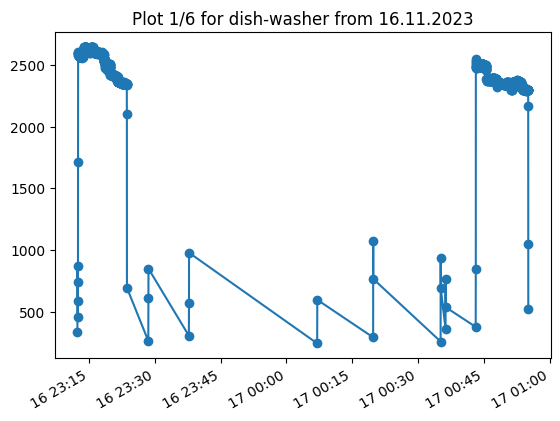

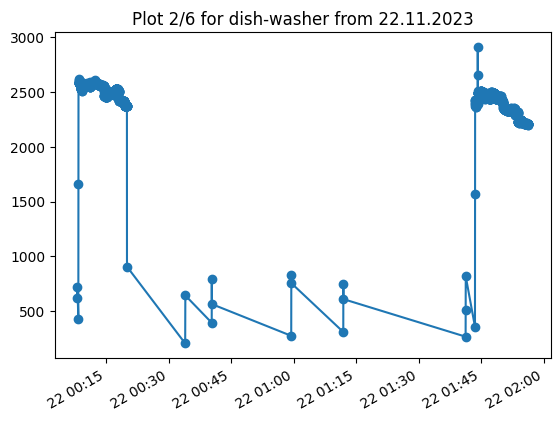

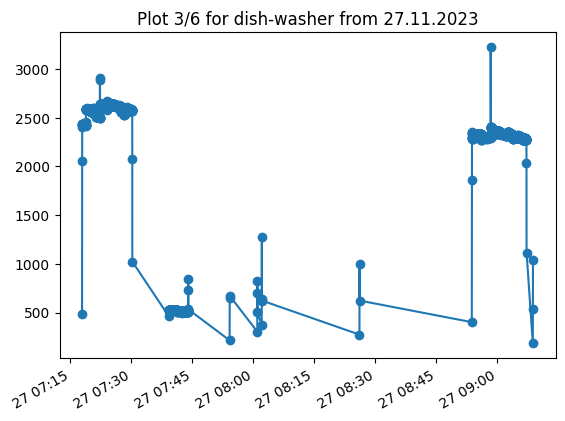

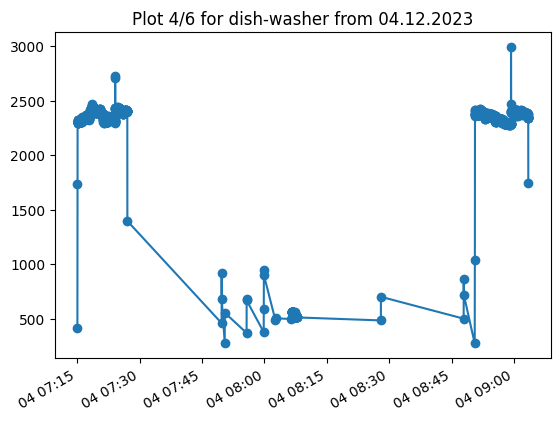

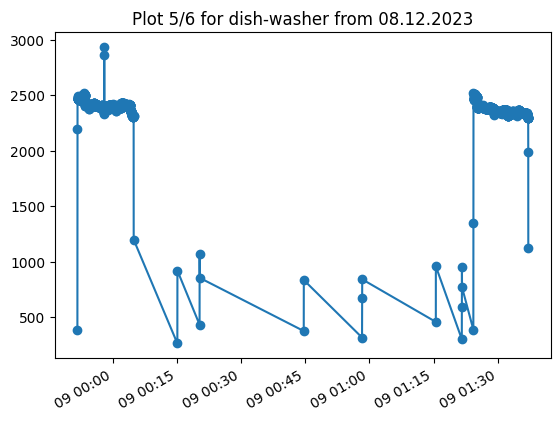

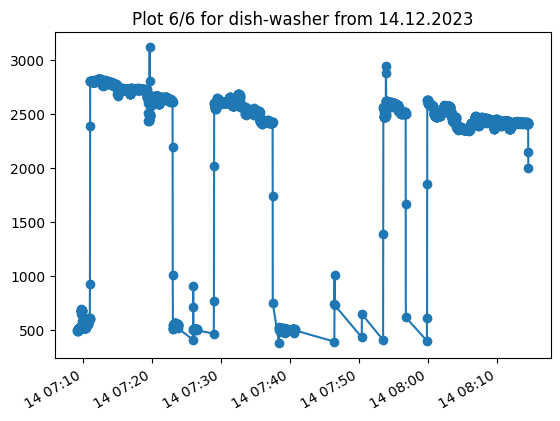

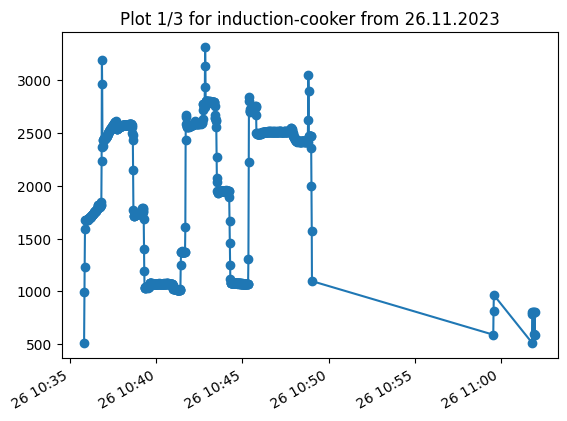

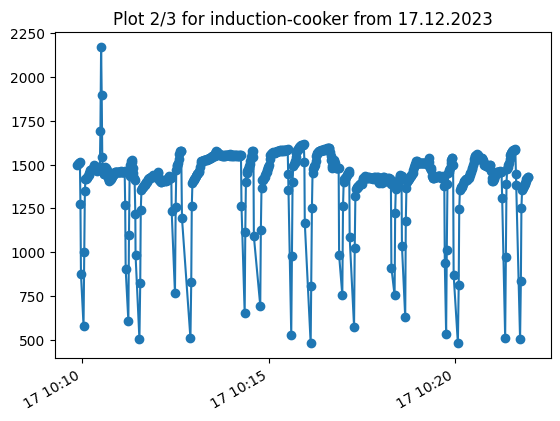

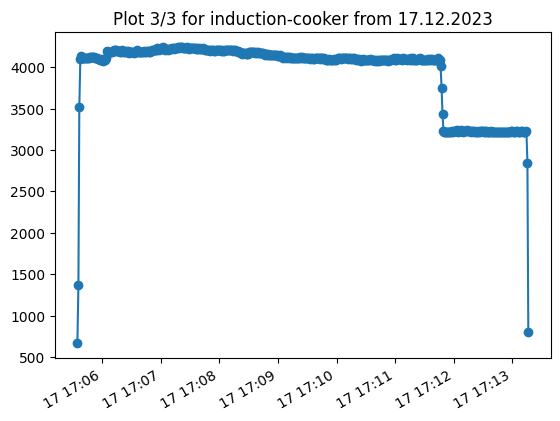

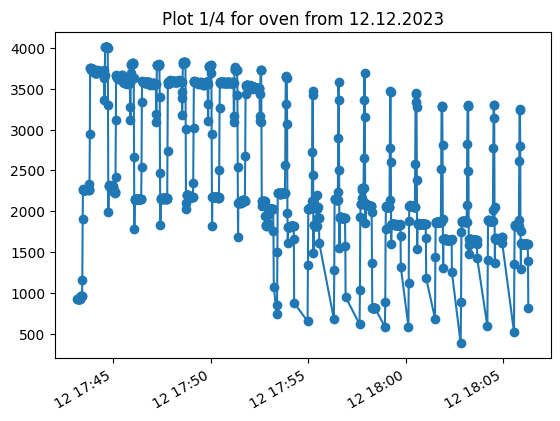

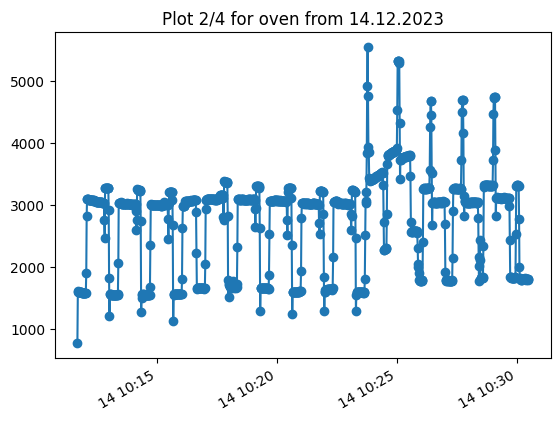

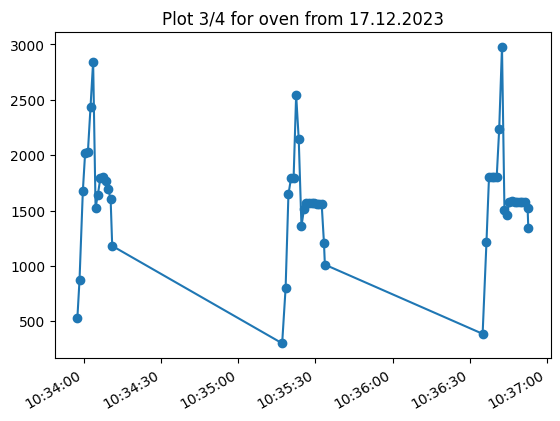

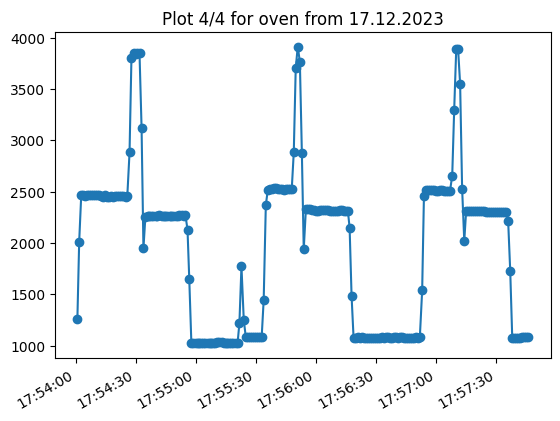

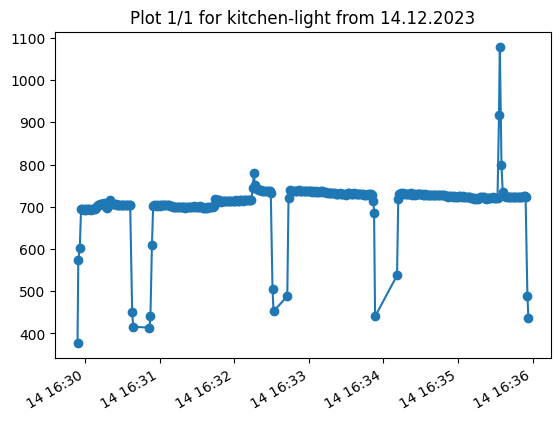

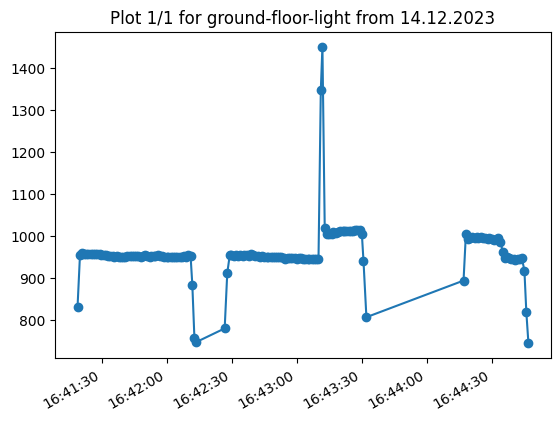

In [5]:
dh.filter_events_by_minpow()
dh.print_events()

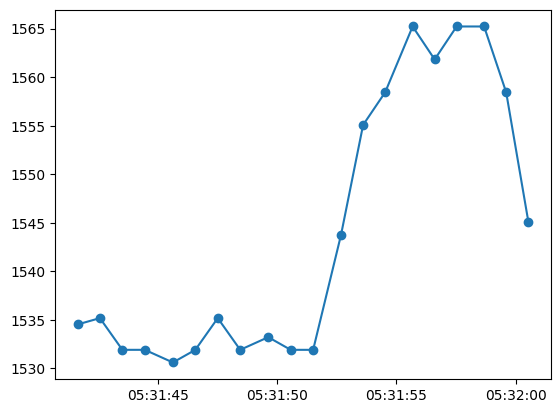

In [6]:
x = pd.to_datetime(dh.event_list[1][8]['timestamp'], utc=True, unit='ms')
y = np.array(dh.event_list[1][8]['value']).astype(float)


x = x[40:60]
y = y[40:60]

f = plt.figure()
a = f.add_subplot()
a.plot(x, y, marker = 'o')

In [7]:
model = Sequential()
# input layer
model.add(Input(shape=(window_length)))
model.add(tf.keras.layers.Reshape(target_shape=(window_length, 1)))
# conv1 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv2 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv3 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# gap
model.add(tf.keras.layers.GlobalAveragePooling1D())
# output layer
model.add(tf.keras.layers.Dense(num_devices, activation="softmax"))

In [8]:
# Kompilieren des Modells
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'msle', 'mae'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['mse', 'msle', 'mae'])
# Anzeigen der Modellzusammenfassung
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 15, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 15, 64)            256       
                                                                 
 batch_normalization (BatchN  (None, 15, 64)           256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 15, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 64)            12352     
                                                                 
 batch_normalization_1 (Batc  (None, 15, 64)           256       
 hNormalization)                                        

In [9]:
#xx, yy = dh.generate_training_data_from_db(window_length)
train_x, train_y, test_x, test_y = dh.generate_training_data_from_events(window_length, event_ratio) #fk: aufteilen der Daten

In [10]:
# train the model
history = model.fit(
            x=train_x,
            y=train_y,
            batch_size=train_x[0].size,
            epochs=epochs,
            verbose=0)

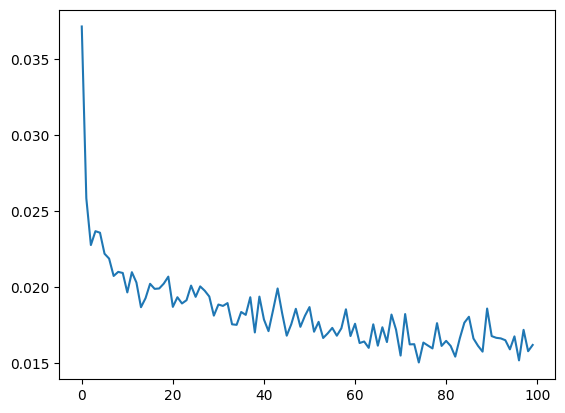

In [11]:
plt.plot(history.history['loss'])


52/52 [==============================] - 0s 3ms/step
+--------------------+-------+---------+-------+---------+
|        device name | total | correct | wrong | percent |
+--------------------+-------+---------+-------+---------+
|   espresso-machine |   657 |     624 |    33 |     94% |
|    washing-machine |   474 |       0 |   474 |      0% |
|        dish-washer |   383 |     370 |    13 |     96% |
|   induction-cooker |    73 |       0 |    73 |      0% |
|  irrigation-system |     0 |       0 |     0 |         |
|               oven |    18 |       8 |    10 |     44% |
|          microwave |     0 |       0 |     0 |         |
|      kitchen-light |    21 |       0 |    21 |      0% |
|  living-room-light |     0 |       0 |     0 |         |
|  dining-room-light |     0 |       0 |     0 |         |
| ground-floor-light |    10 |       0 |    10 |      0% |
|  upper-floor-light |     0 |       0 |     0 |         |
+--------------------+-------+---------+-------+---------+


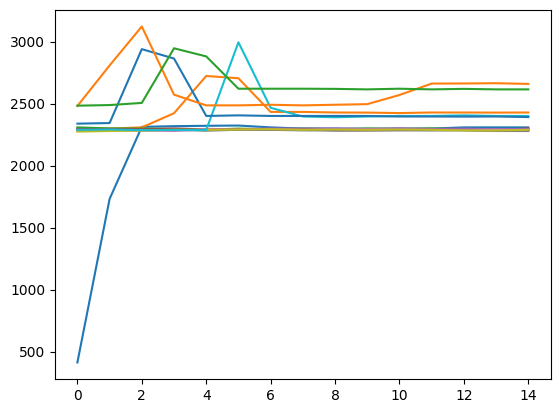

In [12]:
#Prediction with neural network

predict_y = model.predict(test_x)
    
dh.compare_with_testdata(predict_y, test_x, test_y)

In [15]:
# fixed potential bug in line 218. train data ratio: 0.5, with event filter
#+--------------------+-------+---------+-------+---------+
#|        device name | total | correct | wrong | percent |
#+--------------------+-------+---------+-------+---------+
#|   espresso-machine |   657 |     618 |    39 |     94% |
#|    washing-machine |   474 |       0 |   474 |      0% |
#|        dish-washer |   383 |     382 |     1 |     99% |
#|   induction-cooker |    73 |       0 |    73 |      0% |
#|  irrigation-system |     0 |       0 |     0 |         |
#|               oven |    18 |       7 |    11 |     38% |
#|          microwave |     0 |       0 |     0 |         |
#|      kitchen-light |    21 |       0 |    21 |      0% |
#|  living-room-light |     0 |       0 |     0 |         |
#|  dining-room-light |     0 |       0 |     0 |         |
#| ground-floor-light |    10 |       0 |    10 |      0% |
#|  upper-floor-light |     0 |       0 |     0 |         |
#+--------------------+-------+---------+-------+---------+